# Simple example for Gaussian Process Regression  

## Gaussian Process


Gaussian Process defines a prior over functions, which can be converted into a posterior over functions once we have seen some data [2].
A GP assumes that $p(f(x_1),...,f(x_N))$ is jointly Gaussian with some mean $\mu(x)$ and covariance $\Sigma(x)$ given by $\Sigma_{ij} = k(x_i,x_j)$.
Note that it is common to use a mean function of $m(x)=0$ since GP is flexible enough to model the mean arbitrarily well.


Gaussian Process Regression is a non-parametric approach to describe relationships between variables without the need to specify the unknown underlying distribution beforehand. Choosing Gaussian distributions to model the data gives many advantages, for example that the marginal distribution or conditional distribution of any subset from a multivariate normal distribution is also normal. A Gaussian Process (GP) generalizes the multivariate normal to infinite dimension. We describe a GP as a distribution over functions, and specify it by a mean function and a covariance function.

We want to predict function values *Ytest* at concrete points, the test points *Xtest*, by learning the underlying distribution from training data, *Xtrain* and *Ytrain*. The key idea is to model the underlying distribution of *X* together with *Y* as a multivariate normal distribution. The joint probability distribution $P_{X,Y}$ spans the space of possible function values for the function we want to predict. 

Starting with a prior distribution, we collect training data and update the distribution. Therefore, we want to learn the conditional probability $P_{X|Y}$. 

The Gaussian Process is defined by a mean $\mu$ and a covariance matrix $\Sigma$. Usually, the mean value is set to $\mu=0$, because $\mu$ can be mapped back to the resulting function values after the prediction (centering). The covariance matrix $\Sigma$ is defined by the kernel function *K*. We need to sample from the resulting distribution to make predictions [1].


A GP is defined by a mean function $\mu$ and a covariance function $\Sigma$.  The covariance matrix $\Sigma$ is given by the kernel function $k$, such that $\Sigma_{ij} = k(x_i,x_j)$. The goal is to learn the underlying distribution from training data to predict function values at test points [1,2]. 


## Prior

We define the prior as a GP over the test set $X_*$, where each test point is treated as a random variable,



## Test data

In Gaussian Processes, each test point is treated as a random variable. We choose $|Xtest| = N = 50$ linearly-spaced values from 0 to 10 in our example, what makes the corresponding multivariate Gaussian distribution *N*-dimensional.


In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt


# Test Data: N points from 0 to 10
N = 50
Xtest = np.linspace(0, 10, N).reshape(-1,1)

## Kernels

K is positive definite kernel function [2]. If x and x' are deemed by the kernel to be similar, then we expect the output of the function at those points to be similar, too.

Kernels are used as a similarity measure between objects, or points. We define different kernels K to create the covariance matrix $\Sigma$ for *Xtest*. $\Sigma$ describes the shape of the distribution as well as the characteristics of the function we want to predict. The kernel function K is a real-valued function of two arguments, $K(x,x') \in \mathbb{R}$, for $x,x' \in Xtest$, and returns a similarity measure between those points. To retrieve $\Sigma$, we evaluate K on each pairwise combination of *Xtest*. 
$K: \mathbb{R}^n \times \mathbb{R}^n \rightarrow \mathbb{R}$, $\Sigma = Cov(X,X') = K(x,x')$.

$\Sigma_{ij}$ defines the correlation between the i-th and j-th random variable.

RBF (Radial Basis Function): $K(x,x')= \sigma^2 exp(- \frac{||x-x'||^2}{2\ell^2}) $ is a stationary kernel, hence it is invariant to translations (the covariance between x and x' is only dependent on their relative position). It computes the squared distance between points. The scale factor $\sigma^2$ is the variance describing the average distance of the function away from its mean (controls vertical variation). Lengthscale $\ell$ determines the reach of influence on the neighbors (horizontal length scale over which the function varies).

Linear: $K(x,x') = \sigma_b^2 + \sigma^2(x-c)(x'-c)$ is a non-stationary kernel, what means that the covariance between x and x' depends on their absolute locations. Parameter $c$ determines the point on which all posterior functions hinge, and the function will have zero variance. The constant variance $\sigma_b$ describes how far from 0 the height of the function will be at zero, hence adding an uncertain offset to the model [2,3].

In [3]:
def kernel_rbf(x, y, param):
    variance = param[0]
    lengthscale = param[1]
    # Euclidean distance between points
    eucdist = np.sum(x**2,1).reshape(-1,1) + np.sum(y**2,1) - 2*np.dot(x, y.T)
    return variance * np.exp(-0.5 * eucdist * 1/(lengthscale**2))
    
    
def kernel_linear(x, y, param):
    variance = param[0]
    variance_b = param[1]
    offset = param[2]
    return variance_b + variance * np.dot((x-offset), (y-offset).T)



It is possible to combine two kernels by multiplying them together. This is useful when you have more than one type of feature in your data. Common combinations are  
* Linear times Periodic: Functions which are periodic with increasing amplitude as we move away from the origin  
* Linear times Linear: Functions which are quadratic, normally used to produce Bayesian polynomial regression  
* Multidimensional Product: Results in prior over functions that vary across both dimensions (of 2 input dimensions). Function value $f(x,y)$ is only expected to be similar to some other function value $f(x',y')$ if x is close to x' and y is close to y'

Another option is to add two kernels, which can be thought of as an OR operation.   
* Linear plus Periodic: Functions which are periodic with increasing mean as we move away from the origin  
* Adding across dimensions: Prior over functions whcih are a sum of one-dimensional functions. Function $f(x,y)$ is simply a sum of two functions $f_x(x) + f_y(y)$. [3]

In [57]:
def multker(k1, k2):
    return k1*k2


## Prior distribution

We usually assume $\mu = 0$. When we have not observed any training data, we consider the prior distribution $P_X$ that revolves around $\mu = 0$. It has the same dimensionality as the number of test points, N = |Xtest|. In this section, we sample from the prior GP before any data has been observed, to demonstrate how to obtain realizations from a GP. We use the previously introduced kernels and hyperparameters  
* RBF: $\sigma^2 = 0.5,~ \ell = 0.8$  
* Linear: $\sigma^2 = 0.2,~ \sigma_b = 0.3,~ c = 0.7$

to obtain the covariance matrices.

First, we compute the covariance matrix $\Sigma''$ by applying the kernel function $K$ to the test points $Xtest$. Then, we use a trick for sampling: a univariate distribution $x \sim \mathcal{N}(\mu,\sigma^2)$ can be rewritten as $x \sim \mu + \sigma(\mathcal{N}(0,1))$. Similarly, we can express our multivariate dsitribution as $f' \sim \mu + B \mathcal{N}(0,I)$, where $BB^T = \Sigma''$. Using a Cholesky decomposition we can find $B$ and sample from $f'$. 

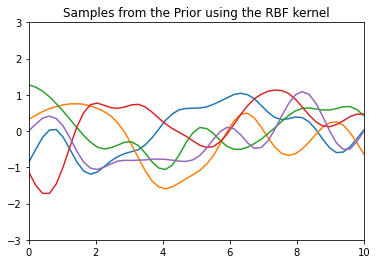

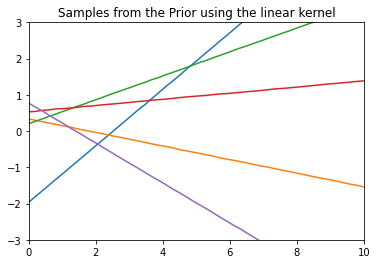

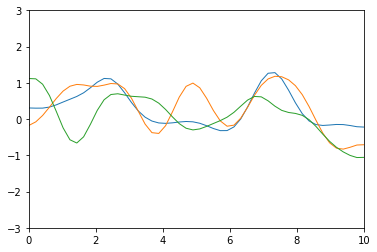

In [9]:
# RBF kernel 
params_rbf = [0.5, 0.8] 
# Covariance matrix with K(x',x')
K_prior_rbf = kernel_rbf(Xtest, Xtest, params_rbf)
# Cholesky decomposition of covariance matrix to find B
B_prior_rbf = np.linalg.cholesky(K_prior_rbf + 1e-5*np.eye(N))  # second term to make it positive definite
# Sample 5 normals for Xtest from the GP prior
f_prior_rbf = np.dot(B_prior_rbf, np.random.normal(size=(N,5)))
# Plot these sampled f'
plt.plot(Xtest, f_prior_rbf)
plt.axis([0, 10, -3, 3])
plt.title('Samples from the Prior using the RBF kernel')
plt.show()

# Linear kernel
params_lin = [0.2, 0.3, 0.7]
K_prior_lin = kernel_linear(Xtest, Xtest, params_lin)
B_prior_lin = np.linalg.cholesky(K_prior_lin + 1e-5*np.eye(N))
f_prior_lin = np.dot(B_prior_lin, np.random.normal(size=(N,5)))
plt.plot(Xtest, f_prior_lin)
plt.axis([0, 10, -3, 3])
plt.title('Samples from the Prior using the linear kernel')
plt.show()


k = kernel_rbf(Xtest, Xtest, params_rbf)
mu = np.zeros(Xtest.shape)
samples = np.random.multivariate_normal(mu.ravel(), k, 3)
for i, sample in enumerate(samples):
    plt.plot(Xtest, sample, lw=1, ls='-', label=f'Sample {i+1}')
    plt.axis([0, 10, -3, 3])




# Combined kernel
#K_prior = multker(K_prior_lin, K_prior_rbf)
#B_prior = np.linalg.cholesky(K_prior + 1e-5*np.eye(N))
#f_prior = np.dot(B_prior, np.random.normal(size=(N,5)))
#plt.plot(Xtest, f_prior)
#plt.axis([0, 10, -3, 3])
#plt.title('Samples from the Prior using the linear kernel')
#plt.show()


## Training data

Now we observe training data Xtrain and Ytrain. We use observations from four experiments with honeybees that were captured in a histogram, indicating the number of living bees after the experiment. From this we calculate the average number of surviving bees as the histogram mean. The available data for $Xtrain = [2,3,5,10]$ bees consists of measurements $Ytrain = [0.64,1.21,2.93,7.76]$. 


In [13]:
# Training Data
#Xtrain = np.array([-3,-2,1,4]).reshape(4,1)
#Ytrain = np.array([1.3,1.5,1.8,1.4]).reshape(4,1)
#Xtrain = np.array([-4, -3, -2, -1, 1]).reshape(5,1)
#Ytrain = np.sin(Xtrain)

# Histograms from Thesis notes (overleaf)
Xtrain = np.array([2,3,5,10]).reshape(4,1)
Ytrain = np.array([0.64,1.21,2.93,7.76]).reshape(4,1)


# Apply Kernel function to train data
#K = kernel(Xtrain, Xtrain, param)
K = kernel_rbf(Xtrain, Xtrain, params)
L = np.linalg.cholesky(K + 0.00005*np.eye(len(Xtrain)))

# Compute mean at test points
#K_s = kernel(Xtrain, Xtest, param)
K_s = kernel_rbf(Xtrain, Xtest, params)
Lk = np.linalg.solve(L, K_s)
mu = np.dot(Lk.T, np.linalg.solve(L, Ytrain)).reshape((N,))
#print(mu)

# Compute standard deviation
s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
stdv = np.sqrt(s2)
#print(stdv)

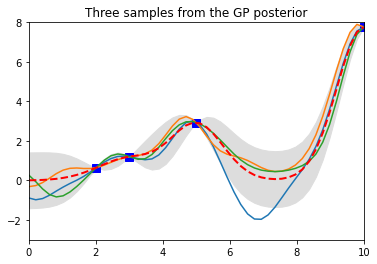

In [14]:
# Draw samples from posterior at test points
L = np.linalg.cholesky(K_ss + 1e-6*np.eye(N) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(N,3)))

plt.plot(Xtrain, Ytrain, 'bs', ms=8)
plt.plot(Xtest, f_post)
plt.gca().fill_between(Xtest.flat, mu-2*stdv, mu+2*stdv, color="#dddddd")
plt.plot(Xtest, mu, 'r--', lw=2)
plt.axis([0, 10, -3, 8])
plt.title('Three samples from the GP posterior')
plt.show()

# References

 [1] Jochen  Görtler,  Rebecca  Kehlbeck,  and  Oliver  Deussen.   A  visual  exploration  of gaussian processes. Distill, 4:e17, 2019.  
 [2] Kevin P. Murphy. Machine Learning: a probabilistic perspective.  MIT press, 2012.  
 [3] https://www.cs.toronto.edu/~duvenaud/cookbook/  
 [4] https://katbailey.github.io/post/gaussian-processes-for-dummies/
 
 Rasmussen, Carl Edward. Gaussian processes in machine learning. In Summer school on machine learning, Springer, 2003.